In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hcmus.pipelines import yolo_augmentation_pipeline
from hcmus.data import AugmentTemplate
from hcmus.utils import viz_utils

2025-05-18 09:24:36.419 | INFO     | hcmus.core.appconfig:<module>:7 - Load DotEnv: True
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
background_project_key = "template"
object_project_key = "train"
augment_template = AugmentTemplate()
all_backgrounds = yolo_augmentation_pipeline.fetch_backgrounds(background_project_key)
all_objects, label_dict = yolo_augmentation_pipeline.fetch_objects(object_project_key)

2025-05-18 09:24:38.097 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 3 tasks available.
Loading tasks: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]
2025-05-18 09:24:38.178 | INFO     | hcmus.lbs._label_studio_connector:download_dataset:48 - No labels input, auto extract 1 labels.
2025-05-18 09:24:38.265 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:121 - Page size is too large, only 1750 tasks available.
Extract objects: 100%|██████████| 1750/1750 [00:03<00:00, 554.15it/s] 


### Background Remove

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import cv2
import random
from typing import List, Tuple
from PIL import Image

# Load U^2-Net from Hugging Face
model = keras.saving.load_model("hf://reidn3r/u2net-image-rembg")


/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 86353.32it/s]


In [5]:
def remove_background(obj_img: np.ndarray) -> np.ndarray:
    img = cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (512, 512))
    img_norm = img_resized / 255.0

    # Model expects shape (1, 320, 320, 3)
    input_tensor = np.expand_dims(img_norm, axis=0).astype(np.float32)

    # Predict alpha matte
    pred = model(input_tensor, training=False)
    if isinstance(pred, list):
        pred = pred[0]
    pred = pred.numpy()[0, :, :, 0]
    pred = cv2.resize(pred, (obj_img.shape[1], obj_img.shape[0]))

    # Normalize and convert to 0-255 alpha
    alpha = (pred * 255).astype(np.uint8)

    # Compose RGBA
    rgba = cv2.cvtColor(obj_img, cv2.COLOR_BGR2BGRA)
    rgba[:, :, 3] = alpha
    return rgba

In [6]:
object_np = all_objects[2].get("object")
img = cv2.cvtColor(object_np, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (512, 512))
img_norm = img_resized / 255.0
input_tensor = np.expand_dims(img_norm, axis=0).astype(np.float32)
pred = model(input_tensor, training=False)[0]
mask = ((pred.numpy()[0, :, :, 0] > 0.01) * 255).astype(np.uint8)

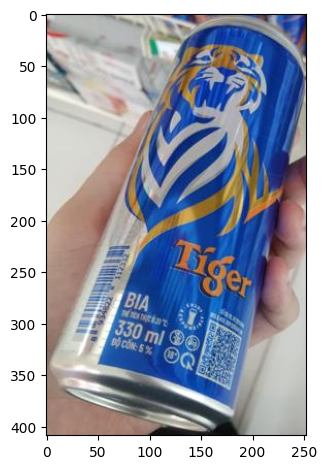

In [7]:
viz_utils.plot_image(object_np)

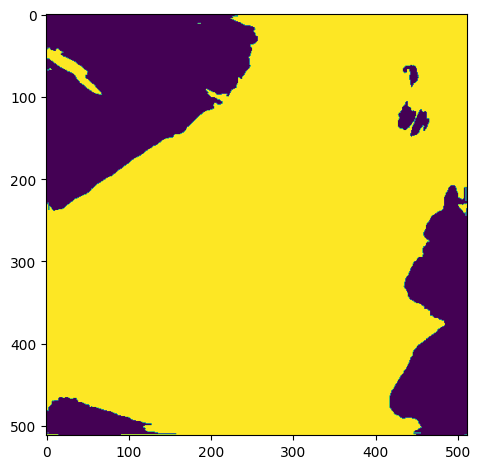

In [8]:
viz_utils.plot_image(mask)

In [9]:
import cv2
import numpy as np

def fill_mask_holes_from_array(mask: np.ndarray, hole_area_threshold: int = 1000) -> np.ndarray:
    if mask.dtype != np.uint8:
        raise ValueError("Mask must be of dtype uint8")
    if len(mask.shape) != 2:
        raise ValueError("Mask must be a 2D array")

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    inv_mask = cv2.bitwise_not(binary_mask)

    contours, _ = cv2.findContours(inv_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < hole_area_threshold:
            cv2.drawContours(binary_mask, [cnt], 0, 255, thickness=cv2.FILLED)

    return binary_mask


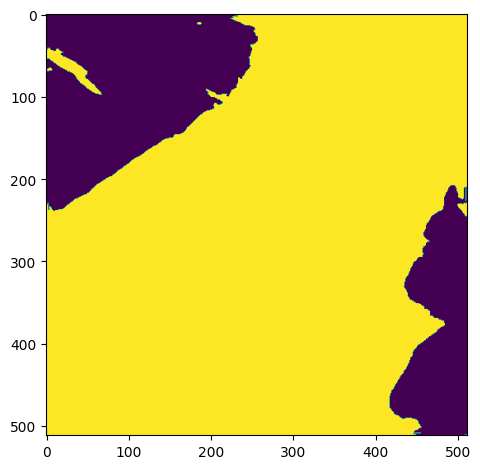

In [10]:
new_mask = fill_mask_holes_from_array(mask, 5000)
viz_utils.plot_image(new_mask)

In [11]:
import cv2
import numpy as np

def clean_and_smooth_mask(mask: np.ndarray, min_component_area: int = 5000, apply_smoothing: bool = True) -> np.ndarray:
    if mask.dtype != np.uint8 or len(mask.shape) != 2:
        raise ValueError("Input must be a 2D uint8 binary mask")

    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

    cleaned_mask = np.zeros_like(binary_mask)

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_component_area:
            cleaned_mask[labels == i] = 255

    if apply_smoothing:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    return cleaned_mask


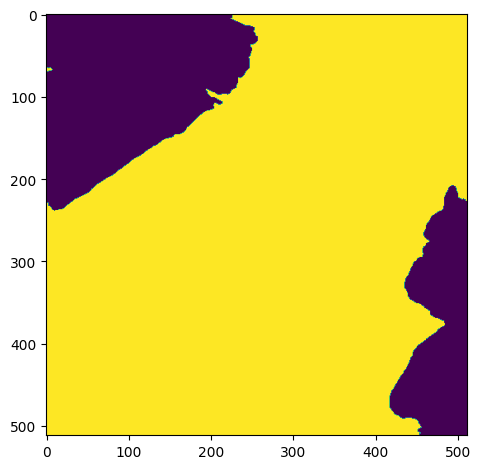

In [12]:
clean_mask = clean_and_smooth_mask(new_mask)
viz_utils.plot_image(clean_mask)

In [13]:
import numpy as np
import cv2

def apply_mask_to_image(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Image must be an RGB image (H, W, 3)")
    if mask.shape != (512, 512):
        raise ValueError("Mask must be of shape (512, 512)")

    resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    _, binary_mask = cv2.threshold(resized_mask, 127, 255, cv2.THRESH_BINARY)

    mask_3ch = cv2.merge([binary_mask] * 3)

    masked_image = cv2.bitwise_and(image, mask_3ch)

    return masked_image


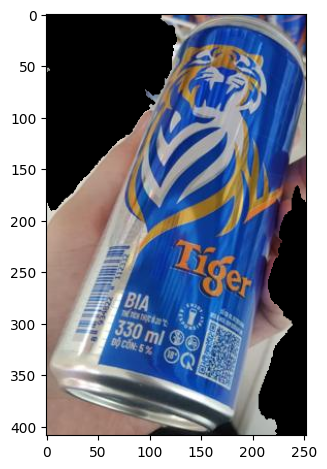

In [14]:
viz_utils.plot_image(apply_mask_to_image(object_np, clean_mask))

In [15]:
import numpy as np
import cv2

def apply_smooth_mask_to_image(image: np.ndarray, mask: np.ndarray, blur_size: int = 11) -> np.ndarray:
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("Image must be an RGB image (H, W, 3)")
    if mask.shape != (512, 512):
        raise ValueError("Mask must be of shape (512, 512)")
    if mask.dtype != np.uint8:
        raise ValueError("Mask must be of dtype uint8")

    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    _, binary_mask = cv2.threshold(mask_resized, 127, 255, cv2.THRESH_BINARY)

    smooth_alpha = cv2.GaussianBlur(binary_mask, (blur_size, blur_size), 0)

    alpha = np.clip(smooth_alpha, 0, 255).astype(np.uint8)

    rgba_image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    rgba_image[:, :, 3] = alpha

    return rgba_image


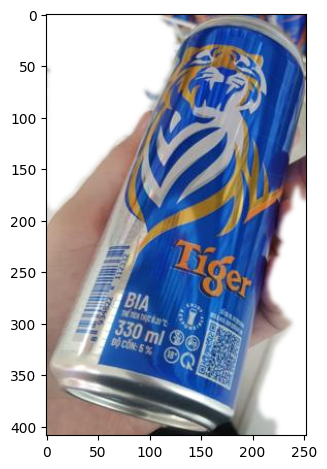

In [16]:
viz_utils.plot_image(apply_smooth_mask_to_image(object_np, clean_mask))